# Oct 28, 2025: distinct community shapes for all k's
and effective number of shapes

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats
from scipy.spatial.distance import jensenshannon, squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from typing import Tuple

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

load membership matrices

In [11]:
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-SLC01/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
grp_df = []
for file in indiv_files:
    with open(file, 'rb') as f:
        df = pickle.load(f)
    grp_df += [df]

In [12]:
boot_files = sorted(glob.glob(f'{ESTIM_path_boot}/individual/boot-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 110/110 [00:01<00:00, 60.70it/s]


In [13]:
pis_df = pd.concat(grp_df + boots_df).reset_index(drop=True)
# pis_df

In [14]:
def make_same_shape(Ms: list):
    num_rois = Ms[0].shape[0]
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    return Rs

In [15]:
cols = [c for c in pis_df.columns if 'pi' in c]

In [16]:
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [17]:
def keep_select_comms(args: ARGS, Ms: list):
    Ms = np.stack(Ms)
    Ms = Ms[:, :, args.select_comms]
    return [Ms[i, :, :] for i in range(Ms.shape[0])]

In [18]:
args.select_comms = np.arange(0, 9) # for pi_1_aligned only
i = 1
cols1 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) < i]
cols2 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) > i]
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols1],
        pis_df[cols[i:i+1]].apply(lambda pis: keep_select_comms(args, pis.to_list())),
        pis_df[cols2],
    ],
    axis=1
)

In [19]:
pis_df

,sub,sbm,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0.257972,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9496124031007752, 0.0, 0.0, 0.0, 0.0503875...","[[0.26990405650233273, 0.6440288789416553, 0.0...","[[0.9201526698804413, 0.06128537650572014, 0.0...","[[0.9878395515527075, 0.009976689198605605, 0....","[[0.9957242760577405, 0.004275723942259544, 0....","[[0.997149517371827, 0.0028504826281730293, 0....","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1,grp,sbm-nd-h,0.141756,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9014084507042254, 0.0, 0.03521126760563380...","[[0.2577782484379964, 0.6056505825165969, 0.10...","[[0.9229028897536316, 0.04418924874364539, 0.0...","[[0.9832180171575026, 0.009469124730781155, 0....","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0018282145279290526, 0....","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0...."
2,grp,sbm-nd-h,0.126375,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9603174603174603, 0.0, 0.02380952380952380...","[[0.062295288485764676, 0.837962962962963, 0.0...","[[0.990532053055227, 0.0034393706396990465, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
3,grp,sbm-nd-h,0.121384,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.15702479338842976, 0.768595041322314, 0.06...","[[0.8881112654215585, 0.10046874960473759, 0.0...","[[0.998572501878287, 0.0, 0.001427498121712997...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
4,grp,sbm-nd-h,0.076945,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.974025974025974, 0.0, 0.025974025974025976...","[[0.6071850227694383, 0.27862602196163366, 0.0...","[[0.9291409601437918, 0.015660401422622795, 0....","[[0.9874163597969866, 0.0046981204267868395, 0...","[[0.9905484400815112, 0.00156604014226228, 0.0...","[[0.9921144802237735, 0.0, 0.00788551977622647...","[[0.9921144802237735, 0.00788551977622647, 0.0...","[[0.9921144802237735, 0.00788551977622647, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,89,sbm-nd-h,0.040787,"[[0.975609756097561, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8958754709498316, 0.023795359904818562, 0....","[[0.0808199036613937, 0.8079089746876055, 0.08...","[[0.9531361388326043, 0.04109101090586787, 0.0...","[[1.0000000000000002, 0.0, 0.0, 0.0], [0.99999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999..."
1272,89,sbm-nd-h,0.038413,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.42105263157894735, 0.0, 0.5789473684210527...","[[0.060403200984918436, 0.9013542628501078, 0....","[[0.9708477102266285, 0.029152289773371563, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1273,89,sbm-nd-h,0.030960,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.12903225806451613, 0.0, 0.8709677419354839...","[[0.008324661810613945, 0.9146722164412071, 0....","[[0.9990750375765985, 0.0, 0.00092496242340154...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 

unique shapes

In [20]:
# OLD

def find_medoids(data, labels):
    medoids = []
    unique_labels = np.unique(labels)
        
    for label in unique_labels:
        cluster_points = data[labels == label]
        distances = euclidean_distances(cluster_points)
        sum_of_distances = distances.sum(axis=1)
        medoid_index_in_cluster = np.argmin(sum_of_distances)
        medoid = cluster_points[medoid_index_in_cluster]
        medoids.append(medoid)
    return np.array(medoids)

def find_points_closest_to_centroids(data, labels, centroids):
    representative_points = []
    
    for i, centroid in enumerate(centroids):
        cluster_points = data[labels == i]
        
        if len(cluster_points) == 0:
            continue
        
        distances = euclidean_distances(cluster_points, centroid.reshape(1, -1))
        closest_point_index = np.argmin(distances)
        
        representative_point = cluster_points[closest_point_index]
        representative_points += [representative_point]
    return np.array(representative_points)
    
    
def k_means_clusters_per_comm(data, max_k=5):
    best_score = -1.0
    best_k = 1

    scores = {}
    for k in range(2, max_k+1):
        if k >= data.shape[0]:
            break
        
        kmeans = KMeans(n_clusters=k, random_state=args.SEED, init='k-means++', n_init='auto')
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        scores[k] = score
        
        if score > best_score:
            best_score = score
            best_k = k
        
        # If no meaningful clustering was found (all scores are low), default to k=1
        if best_score < 0.1:
            best_k = 1
        
        # Rerun with the best k to get the final, stable results
        if best_k == 1:
            centroids = data.mean(axis=0, keepdims=True)
            labels = np.zeros(data.shape[0], dtype=int)
        else:
            kmeans_final =KMeans(n_clusters=best_k, random_state=args.SEED, init='k-means++', n_init='auto')
            kmeans_final.fit(data)
            centroids = kmeans_final.cluster_centers_
            labels = kmeans_final.labels_
        
        # centroids = find_medoids(data, labels)
        centroids = find_points_closest_to_centroids(data, labels, centroids)
    return centroids, labels, scores, best_k

def find_archetypes_per_comm(data, max_k=5, absence_threshold=0.25):
    """Finds community archetypes, explicitly treating "absent" forms as a separate cluster."""
    norms = np.linalg.norm(data, axis=1)
    is_absent = norms < absence_threshold
    
    active_indices = np.where(~is_absent)[0]
    absent_indices = np.where(is_absent)[0]
    
    active_data = data[active_indices]
    final_labels = np.zeros(data.shape[0], dtype=int)
    
    if len(active_data) > 0:
        scaler = StandardScaler()
        # active_data = scaler.fit_transform(active_data)
        active_centroids, active_labels, scores, active_k = k_means_clusters_per_comm(active_data, max_k)
        final_labels[active_indices] = active_labels + 1
    else:
        active_centroids = np.array([])
    
    final_labels[absent_indices] = 0
    absent_centroids = np.zeros((1, data.shape[1]))
    
    if active_k > 0:
        total_centroids = np.vstack([absent_centroids, active_centroids])
        total_k = active_k + 1
    else:
        total_centroids = absent_centroids
        total_k = 1
    return total_centroids, final_labels, scores, total_k

In [21]:
# NEW

def k_means_clusters_per_comm(data, k):
    
    gmm = GaussianMixture(
        n_components=k, 
        covariance_type='spherical',
        random_state=args.SEED,
        n_init=100,
    )
    gmm.fit(data)
    labels = gmm.predict(data)
    bic = gmm.bic(data)
    sil = silhouette_score(data, labels)
    centroids = gmm.means_
    return labels, bic, sil, centroids

def find_archetypes_per_comm(col, comm, data, ks, absence_threshold=0.25):
    """Finds community archetypes, explicitly treating "absent" forms as a separate cluster."""
    norms = np.linalg.norm(data, axis=1)
    is_absent = norms < absence_threshold
    
    active_indices = np.where(~is_absent)[0]
    absent_indices = np.where(is_absent)[0]
    
    active_data = data[active_indices]
    # final_labels = np.zeros(data.shape[0], dtype=int)
    absent_centroids = np.zeros((1, data.shape[1]))
    
    all_ks = []
    all_final_labels = []
    all_centroids = []
    bic_scores = []
    sil_scores = []
    # if len(active_data) > 0:
    for k in tqdm(ks):
        labels, bic, sil, centroids = k_means_clusters_per_comm(active_data, k)
        final_labels = np.zeros(data.shape[0], dtype=int)
        final_labels[active_indices] = labels + 1
        final_centroids = np.vstack([absent_centroids, centroids])
        
        all_ks += [k + 1] # because 1st cluster is all 0's
        all_final_labels += [final_labels]
        all_centroids += [final_centroids]
        bic_scores += [bic]
        sil_scores += [sil]
        
    return pd.DataFrame(dict(
        sbm=SBM,
        col=col, 
        comm=comm,
        k=all_ks,
        labels=all_final_labels,
        centroids=all_centroids,
        bic=bic_scores,
        sil=sil_scores,
    ))

In [22]:
def compute_cluster_probabilities(clusters, omegas, num_clusters):
    # if len(omegas) > 1:
        return np.bincount(clusters, weights=omegas, minlength=num_clusters)
    # else:
    #     return np.array([1.0])

def compute_effective_number_of_shapes(probs):
    return np.exp(stats.entropy(probs))

def get_unique_configs(config_matrix, clusters):
    # encdr : num_modes x num_clusters
    encdr = OneHotEncoder(
        sparse_output=False,
    ).fit_transform(clusters.reshape(-1, 1))
    # mean configuration within each cluster, 
    # config_matrix.T : num_rois x num_modes
    # cluster_configs : num_rois x num_clusters (per comm)
    unique_configs =  np.round(
        config_matrix.T @ encdr / encdr.sum(axis=0),
        decimals=3,
    )
    return unique_configs

In [23]:
analysis_df = []
centroids_df = []

for col in cols[1:2]:
    Ms = np.stack(pis_df[col].to_list())
    num_points, num_rois, num_comms = Ms.shape
    
    ks = np.arange(2, 15)
    comms_df = []
    for comm in range(num_comms):
        comm_df = find_archetypes_per_comm(col, comm, Ms[:, :, comm], ks)
        comms_df += [comm_df]
    comms_df = pd.concat(comms_df).reset_index(drop=True)

100%|██████████| 13/13 [00:47<00:00,  3.66s/it]


In [24]:
comms_df

,sbm,col,comm,k,labels,centroids,bic,sil
0,sbm-nd-h,pi_1_aligned,0,3,"[1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-186406.849221,0.206559
1,sbm-nd-h,pi_1_aligned,0,4,"[3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 2, 2, 2, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-211027.406129,0.143685
2,sbm-nd-h,pi_1_aligned,0,5,"[3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 2, 4, 4, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-234824.829234,0.165511
3,sbm-nd-h,pi_1_aligned,0,6,"[2, 2, 2, 2, 2, 5, 2, 2, 4, 2, 2, 4, 5, 5, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-255443.121940,0.135666
4,sbm-nd-h,pi_1_aligned,0,7,"[5, 5, 5, 5, 5, 4, 5, 5, 3, 5, 5, 3, 4, 4, 6, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-267684.854867,0.125935
...,...,...,...,...,...,...,...,...
112,sbm-nd-h,pi_1_aligned,8,11,"[3, 4, 6, 3, 3, 1, 4, 7, 3, 8, 5, 10, 7, 3, 7,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-492618.243310,0.131668
113,sbm-nd-h,pi_1_aligned,8,12,"[2, 4, 6, 2, 2, 10, 4, 9, 2, 10, 6, 3, 9, 2, 9...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-502262.565125,0.141132
114,sbm-nd-h,pi_1_aligned,8,13,"[3, 7, 9, 3, 3, 11, 7, 8, 3, 6, 6, 4, 8, 3, 8,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-510801.718935,0.149157
115,sbm-nd-h,pi_1_aligned,8,14,"[4, 3, 5, 4, 4, 2, 3, 9, 4, 8, 5, 12, 9, 4, 9,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-516894.692271,0.122129


In [25]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/all-ks'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/desc-centroids.pkl', 'wb') as f:
    pickle.dump(comms_df, f)

In [23]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/all-ks'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/desc-centroids.pkl', 'rb') as f:
    comms_df = pickle.load(f)

IndexError: index 5 is out of bounds for axis 0 with size 5

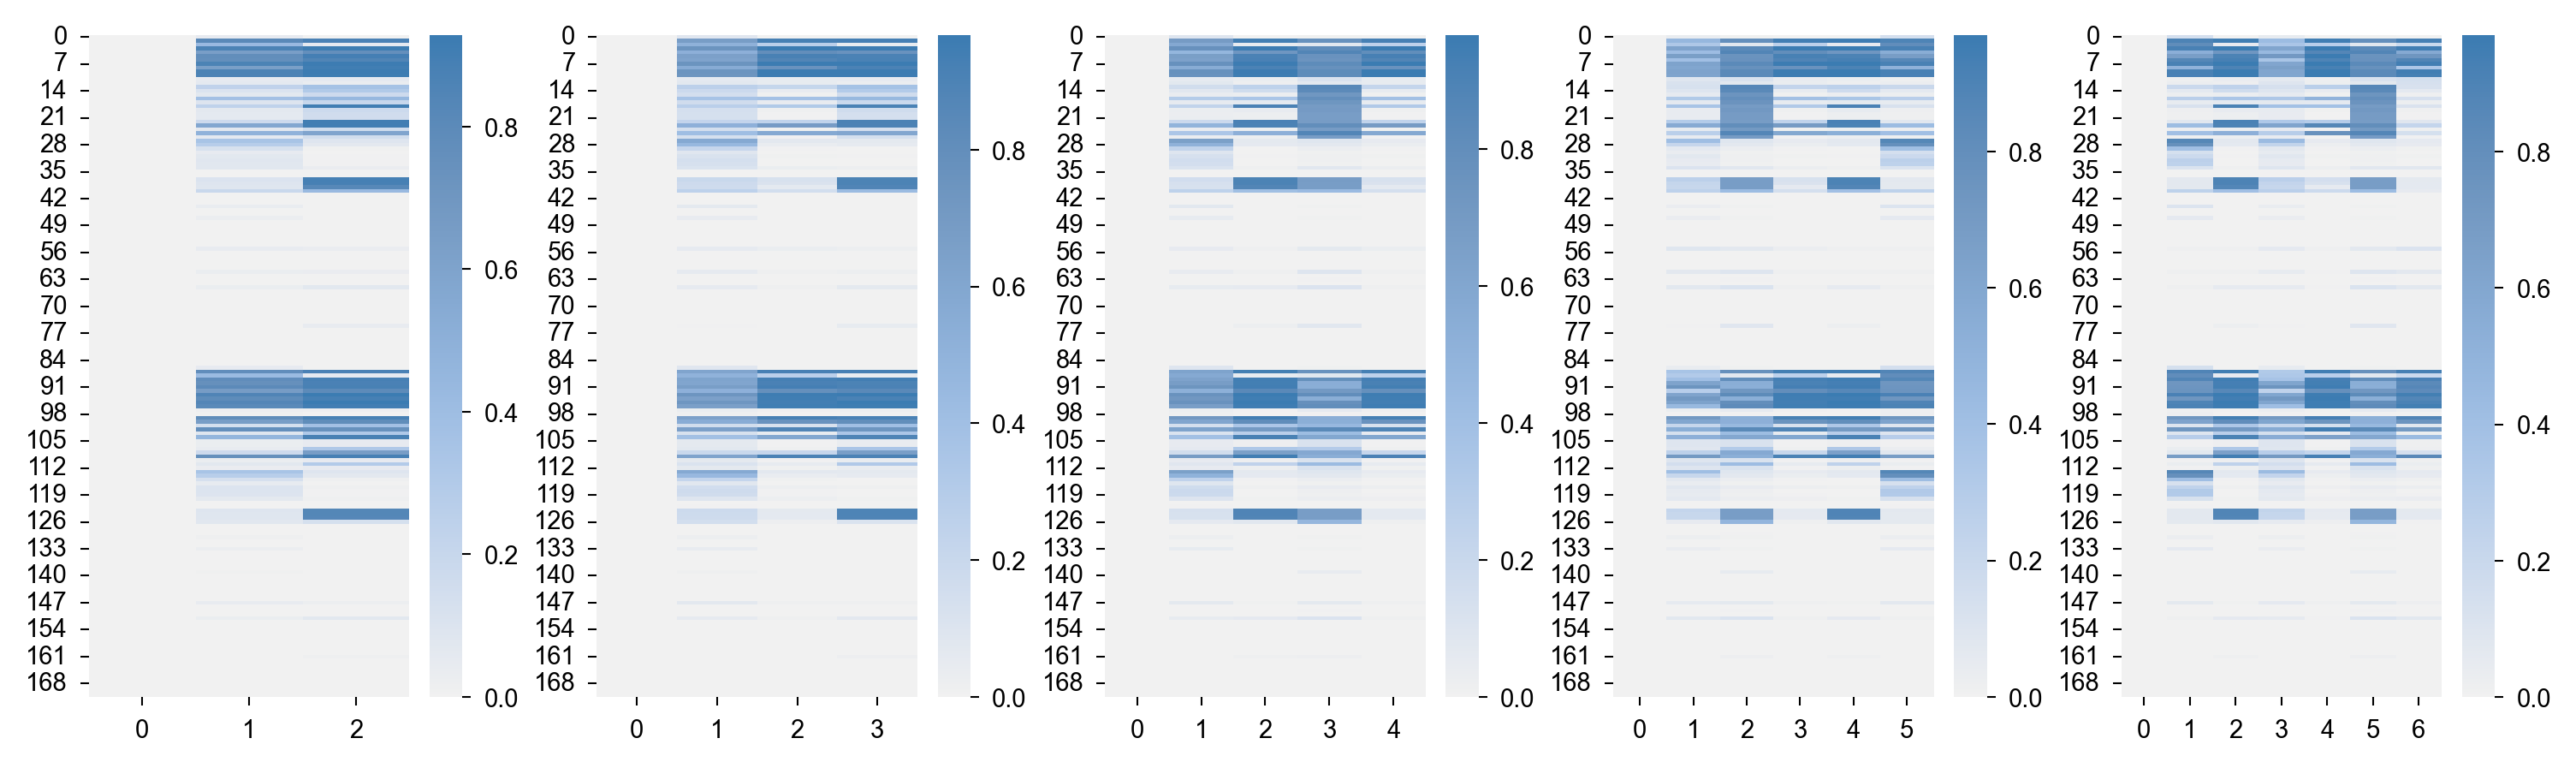

In [24]:
nrows = 1
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 3*nrows), dpi=300)
fig.tight_layout()

for idx, row in comms_df[comms_df['comm'] == 1].reset_index(drop=True).iterrows():
    X = row['centroids'].T
    k = row['k']
    sil = row['sil']
    
    ax = axs[idx]
    sns.heatmap(X, ax=ax, cmap=cc.cm.CET_L12)

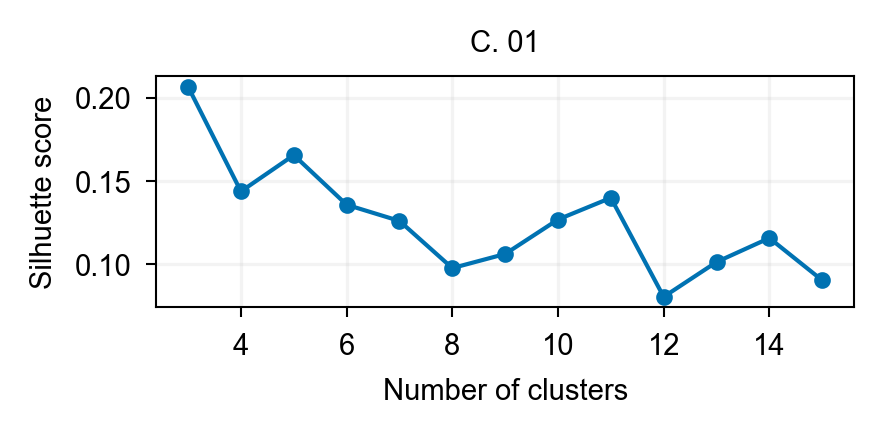

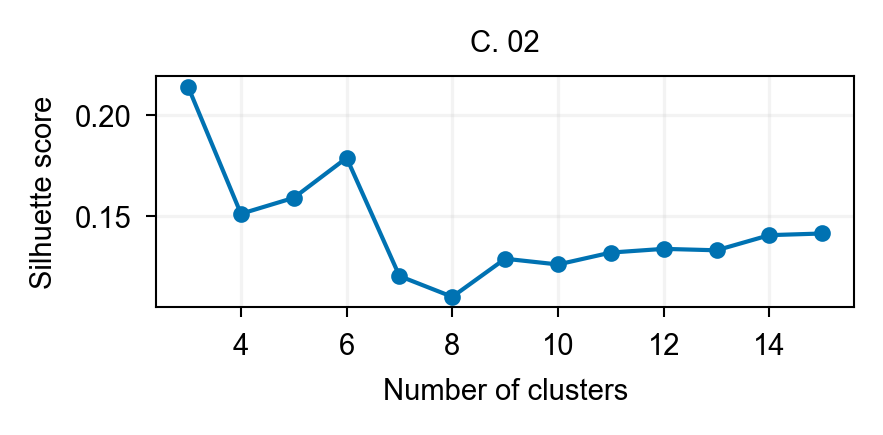

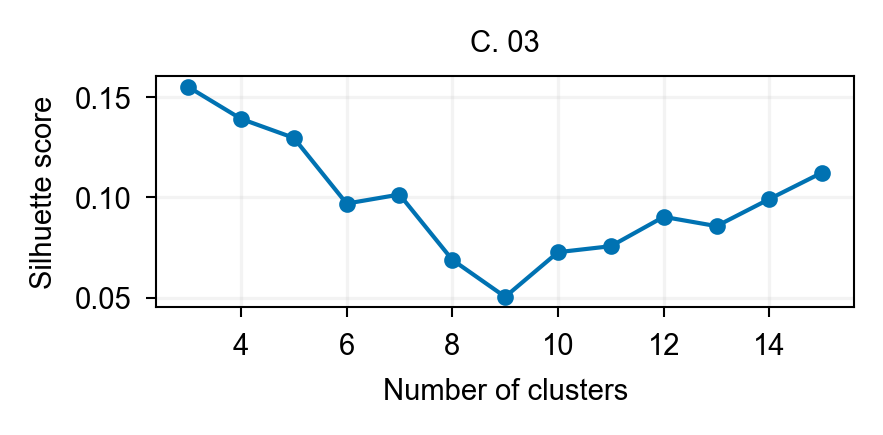

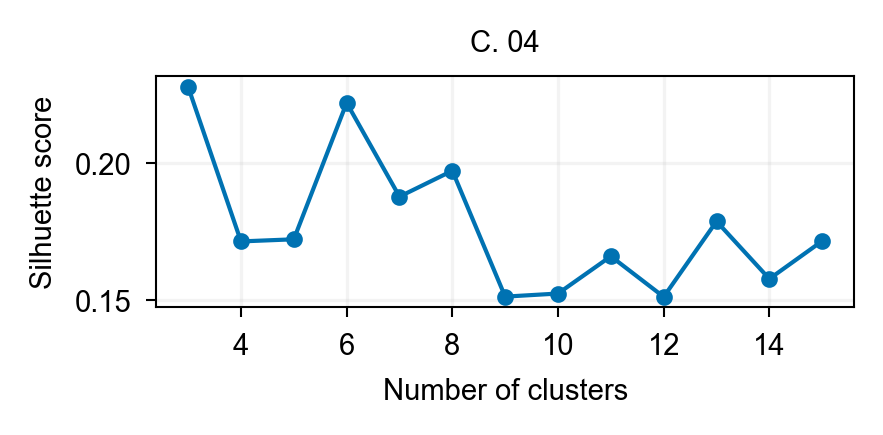

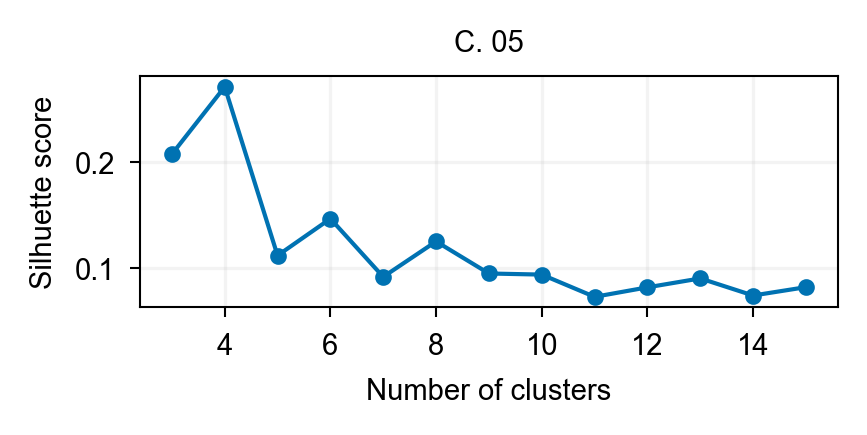

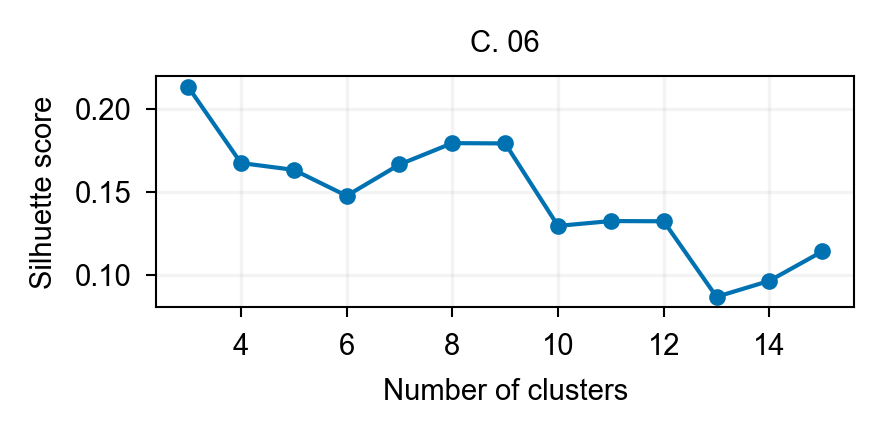

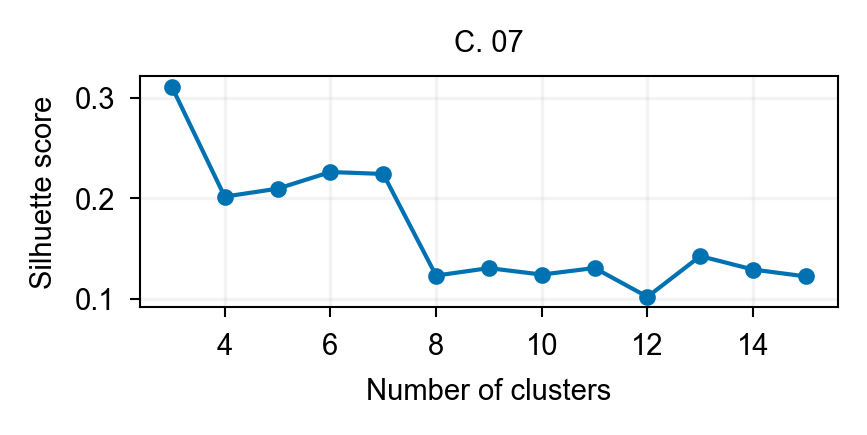

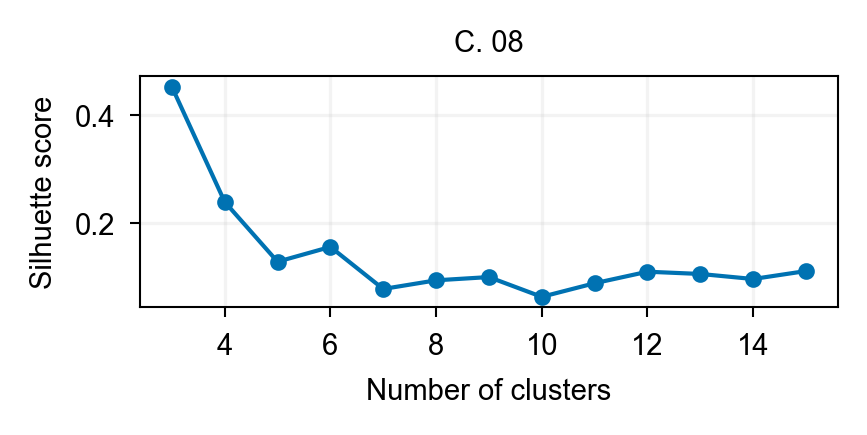

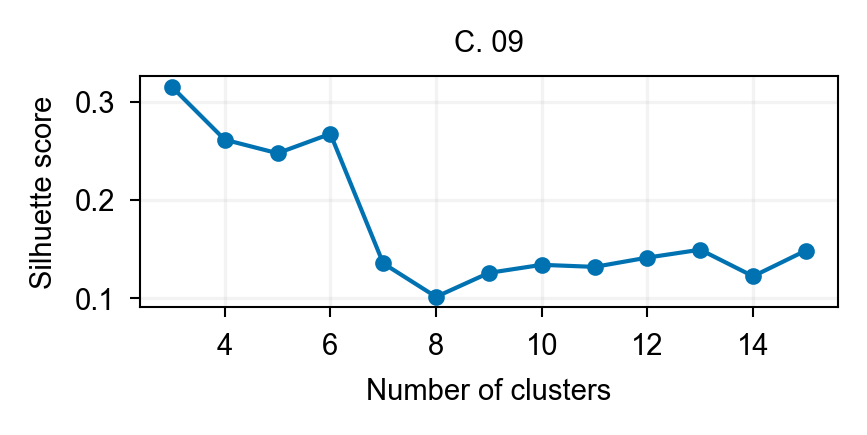

In [24]:
for comm, group in comms_df.groupby('comm'):
    col = group['col'].to_list()[0]
    level = level = int(col.replace('pi_', '').replace('_aligned', ''))
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 1), dpi=300)    
    ax.plot(group['k'], group['sil'], c=CUD_COLORS[0], marker='.')
    # ax.plot(group['k'], group['bic'], c=CUD_COLORS[1], marker='.')
    ax.grid(alpha=0.15)
    ax.set(title=f'C. {comm+1:02d}', ylabel=f'Silhuette score', xlabel=f'Number of clusters')
    
    folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/all-ks/silhuette-plots'
    os.makedirs(folder, exist_ok=True)
    fig.savefig(f'{folder}/level-{level}_comm-{comm:02d}.svg', transparent=True, dpi=300, bbox_inches='tight')
    # break

In [25]:
comms_df

,sbm,col,comm,k,labels,centroids,bic,sil
0,sbm-nd-h,pi_1_aligned,0,3,"[1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-186406.849221,0.206559
1,sbm-nd-h,pi_1_aligned,0,4,"[3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 2, 2, 2, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-211027.406129,0.143685
2,sbm-nd-h,pi_1_aligned,0,5,"[3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 2, 4, 4, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-234824.829234,0.165511
3,sbm-nd-h,pi_1_aligned,0,6,"[2, 2, 2, 2, 2, 5, 2, 2, 4, 2, 2, 4, 5, 5, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-255443.121940,0.135666
4,sbm-nd-h,pi_1_aligned,0,7,"[5, 5, 5, 5, 5, 4, 5, 5, 3, 5, 5, 3, 4, 4, 6, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-267684.854867,0.125935
...,...,...,...,...,...,...,...,...
112,sbm-nd-h,pi_1_aligned,8,11,"[3, 4, 6, 3, 3, 1, 4, 7, 3, 8, 5, 10, 7, 3, 7,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-492618.243310,0.131668
113,sbm-nd-h,pi_1_aligned,8,12,"[2, 4, 6, 2, 2, 10, 4, 9, 2, 10, 6, 3, 9, 2, 9...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-502262.565125,0.141132
114,sbm-nd-h,pi_1_aligned,8,13,"[3, 7, 9, 3, 3, 11, 7, 8, 3, 6, 6, 4, 8, 3, 8,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-510801.718935,0.149157
115,sbm-nd-h,pi_1_aligned,8,14,"[4, 3, 5, 4, 4, 2, 3, 9, 4, 8, 5, 12, 9, 4, 9,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-516894.692271,0.122129


In [29]:
analysis_df = []

for idx, row in tqdm(comms_df.iterrows()):
    k, comm, labels = row[['k', 'comm', 'labels']]
    
    df = pd.concat(
        [
            pis_df[['sub', 'sbm', 'omega']],
            pd.Series(labels, name='labels'),
        ],
        axis=1,
    )
    
    for sub, group in df.groupby('sub'):
        clusters = np.array(group['labels'].to_list())
        omegas = group['omega']
        ps = compute_cluster_probabilities(clusters, omegas, k)
        Ec = compute_effective_number_of_shapes(ps)
        
        Cs = np.stack(pis_df[(pis_df['sub'] == sub)][col].to_list())
        unique_configs = get_unique_configs(Cs[:, :, comm], clusters)
        
        arow = pd.DataFrame(dict(
            sub=[sub],
            sbm=[SBM],
            col=[col],
            k=[k],
            comm=[comm],
            clusters=[clusters],
            eff_num_shapes=[Ec],
            strengths=[ps],
            configs=[np.round(unique_configs, decimals=3)],
            # scores=[scores],
        ))
        analysis_df += [arow]
analysis_df = pd.concat(analysis_df).reset_index(drop=True)

117it [00:21,  5.49it/s]


In [30]:
analysis_df

,sub,sbm,col,k,comm,clusters,eff_num_shapes,strengths,configs
0,00,sbm-nd-h,pi_1_aligned,3,0,"[2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, ...",1.968321,"[0.0, 0.4108901780356072, 0.589109821964393]","[[0.925, 0.795], [0.0, 0.004], [0.0, 0.007], [..."
1,01,sbm-nd-h,pi_1_aligned,3,0,[2],1.000000,"[0.0, 0.0, 1.0]","[[0.093], [0.118], [0.003], [0.001], [0.0], [0..."
2,02,sbm-nd-h,pi_1_aligned,3,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",1.000000,"[0.0, 0.0, 1.0]","[[0.038], [0.0], [0.0], [0.0], [0.0], [0.0], [..."
3,03,sbm-nd-h,pi_1_aligned,3,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",1.441286,"[0.119304, 0.0, 0.880696]","[[0.008, 0.229], [0.0, 0.0], [0.0, 0.0], [0.0,..."
4,04,sbm-nd-h,pi_1_aligned,3,0,[1],1.000000,"[0.0, 1.0, 0.0]","[[0.884], [0.0], [0.006], [0.0], [0.0], [0.0],..."
...,...,...,...,...,...,...,...,...,...
12982,84,sbm-nd-h,pi_1_aligned,15,8,"[3, 9, 3, 4, 4, 4, 4, 9, 9, 9, 9, 4, 9, 9]",2.993452,"[0.0, 0.0, 0.0, 0.30567446822697875, 0.3348269...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
12983,85,sbm-nd-h,pi_1_aligned,15,8,"[12, 14, 9, 5, 14, 14, 14, 14, 5, 5, 14, 14, 1...",3.258767,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.17843960290492372,...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
12984,87,sbm-nd-h,pi_1_aligned,15,8,"[5, 5, 10, 5, 5, 5, 10, 2, 5, 9, 10, 5, 6]",2.253231,"[0.0, 0.0, 0.04390211375608455, 0.0, 0.0, 0.71...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
12985,89,sbm-nd-h,pi_1_aligned,15,8,"[6, 6, 6, 6, 9, 14, 12, 6, 7, 13, 8, 6]",2.959323,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7136266666666...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."


In [ ]:
# analysis_df = []
# centroids_df = []

# for col in cols[1:2]:
#     Ms = np.stack(pis_df[col].to_list())
#     num_comms = Ms.shape[-1]

#     for comm in range(num_comms):
#         try:
#             centroids, labels, scores, k = find_archetypes_per_comm(Ms[:, :, comm], max_k=10)
#             comm_df = pd.concat(
#                 [
#                     pis_df[['sub', 'sbm', 'omega']],
#                     pd.Series(labels, name='labels'),
#                 ],
#                 axis=1,
#             )
            
#             for sub, group in comm_df.groupby('sub'):
#                 clusters = np.array(group['labels'].to_list())
#                 omegas = group['omega']
#                 ps = compute_cluster_probabilities(
#                     clusters, omegas, k,
#                 )
#                 eff_num_shapes = compute_effective_number_of_shapes(ps)
                
#                 Cs = np.stack(pis_df[(pis_df['sub'] == sub)][col].to_list())
#                 unique_configs = get_unique_configs(Cs[:, :, comm], clusters)
                
#                 arow = pd.DataFrame(dict(
#                     sub=[sub],
#                     sbm=[SBM],
#                     col=[col],
#                     comm=[comm],
#                     clusters=[clusters],
#                     eff_num_shapes=[eff_num_shapes],
#                     strengths=[ps],
#                     configs=[np.round(unique_configs, decimals=3)],
#                     scores=[scores],
#                 ))
#                 analysis_df += [arow]
                
#             crow = pd.DataFrame(dict(
#                 sbm=[SBM],
#                 col=[col],
#                 comm=[comm],
#                 centroids=[np.round(centroids, decimals=3)],
#             ))
#             centroids_df += [crow]
#                 # break
#         except:
#             pass
# analysis_df = pd.concat(analysis_df).reset_index(drop=True)
# centroids_df = pd.concat(centroids_df).reset_index(drop=True)

In [ ]:
# analysis_df[analysis_df['col'].isin(['pi_1_aligned'])]

,sub,sbm,col,comm,clusters,eff_num_shapes,strengths,configs,scores
0,00,sbm-nd-h,pi_1_aligned,0,"[2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1.439717,"[0.0, 0.11875975195039007, 0.88124024804961]","[[0.532, 0.909], [0.01, 0.001], [0.009, 0.003]...","{2: 0.24785251485851262, 3: 0.2325664212963358..."
1,01,sbm-nd-h,pi_1_aligned,0,[1],1.000000,"[0.0, 1.0, 0.0]","[[0.093], [0.118], [0.003], [0.001], [0.0], [0...","{2: 0.24785251485851262, 3: 0.2325664212963358..."
2,02,sbm-nd-h,pi_1_aligned,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.000000,"[0.0, 1.0, 0.0]","[[0.038], [0.0], [0.0], [0.0], [0.0], [0.0], [...","{2: 0.24785251485851262, 3: 0.2325664212963358..."
3,03,sbm-nd-h,pi_1_aligned,0,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.441286,"[0.119304, 0.880696, 0.0]","[[0.008, 0.229], [0.0, 0.0], [0.0, 0.0], [0.0,...","{2: 0.24785251485851262, 3: 0.2325664212963358..."
4,04,sbm-nd-h,pi_1_aligned,0,[2],1.000000,"[0.0, 0.0, 1.0]","[[0.884], [0.0], [0.006], [0.0], [0.0], [0.0],...","{2: 0.24785251485851262, 3: 0.2325664212963358..."
...,...,...,...,...,...,...,...,...,...
994,84,sbm-nd-h,pi_1_aligned,8,"[1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1]",1.891830,"[0.0, 0.6651730346069215, 0.33482696539307866]","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","{2: 0.35426329332051537, 3: 0.3251983599116074..."
995,85,sbm-nd-h,pi_1_aligned,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.000000,"[0.0, 1.0, 0.0]","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","{2: 0.35426329332051537, 3: 0.3251983599116074..."
996,87,sbm-nd-h,pi_1_aligned,8,"[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]",1.197400,"[0.0, 0.9560978862439155, 0.04390211375608455]","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","{2: 0.35426329332051537, 3: 0.3251983599116074..."
997,89,sbm-nd-h,pi_1_aligned,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.000000,"[0.0, 0.9999999999999999, 0.0]","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","{2: 0.35426329332051537, 3: 0.3251983599116074..."


In [ ]:
# centroids_df

,sbm,col,comm,centroids
0,sbm-nd-h,pi_1_aligned,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,sbm-nd-h,pi_1_aligned,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,sbm-nd-h,pi_1_aligned,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,sbm-nd-h,pi_1_aligned,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,sbm-nd-h,pi_1_aligned,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,sbm-nd-h,pi_1_aligned,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,sbm-nd-h,pi_1_aligned,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,sbm-nd-h,pi_1_aligned,7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,sbm-nd-h,pi_1_aligned,8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
# folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
# os.makedirs(folder, exist_ok=True)

# with open(f'{folder}/desc-centroids.pkl', 'wb') as f:
#     pickle.dump(centroids_df, f)

WHICH are the most popular shapes of a comm. in the population: strengths?

In [31]:
def plot_strengths(data, comm):
    num_forms = data.shape[1]
    fig, ax = plt.subplots(1, 1, figsize=(num_forms*0.5, 1), dpi=300)

    def connect_points(ax, data):
        for i in range(data.shape[0]):
            for j in range(data.shape[1]-1):
                x1, x2 = j, j+1
                y1, y2 = data[i, x1], data[i, x2]
                color = 'grey' #CUD_COLORS[1] if y1 > y2 else CUD_COLORS[0]
                alpha = 0.15
                linewidth = 0.5
                linestyle = '-'
                ax.plot(
                    [x1, x2], [y1, y2], 
                    color=color, alpha=alpha, 
                    linewidth=linewidth, 
                    linestyle=linestyle,
                )
        return ax

    sns.boxplot(
        data=data, 
        ax=ax,
        color='grey',
        fill=False, 
        width=0.5, 
        linewidth=1,
        fliersize=0,
        capprops=dict(linewidth=0),
    )

    sns.stripplot(
        data=data, 
        ax=ax,
        color=CUD_COLORS[0],
        size=2,
        marker='o',
        alpha=0.5, 
        jitter=False,
    )

    ax = connect_points(ax, data)

    sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    ax.set(xticklabels=[f'T. {i}' for i in range(num_forms)])
    ax.set(ylabel=f'C. {comm+1:02d}')
    ax.grid(alpha=0.15)
    return fig

In [32]:
analysis_df

,sub,sbm,col,k,comm,clusters,eff_num_shapes,strengths,configs
0,00,sbm-nd-h,pi_1_aligned,3,0,"[2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, ...",1.968321,"[0.0, 0.4108901780356072, 0.589109821964393]","[[0.925, 0.795], [0.0, 0.004], [0.0, 0.007], [..."
1,01,sbm-nd-h,pi_1_aligned,3,0,[2],1.000000,"[0.0, 0.0, 1.0]","[[0.093], [0.118], [0.003], [0.001], [0.0], [0..."
2,02,sbm-nd-h,pi_1_aligned,3,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",1.000000,"[0.0, 0.0, 1.0]","[[0.038], [0.0], [0.0], [0.0], [0.0], [0.0], [..."
3,03,sbm-nd-h,pi_1_aligned,3,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",1.441286,"[0.119304, 0.0, 0.880696]","[[0.008, 0.229], [0.0, 0.0], [0.0, 0.0], [0.0,..."
4,04,sbm-nd-h,pi_1_aligned,3,0,[1],1.000000,"[0.0, 1.0, 0.0]","[[0.884], [0.0], [0.006], [0.0], [0.0], [0.0],..."
...,...,...,...,...,...,...,...,...,...
12982,84,sbm-nd-h,pi_1_aligned,15,8,"[3, 9, 3, 4, 4, 4, 4, 9, 9, 9, 9, 4, 9, 9]",2.993452,"[0.0, 0.0, 0.0, 0.30567446822697875, 0.3348269...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
12983,85,sbm-nd-h,pi_1_aligned,15,8,"[12, 14, 9, 5, 14, 14, 14, 14, 5, 5, 14, 14, 1...",3.258767,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.17843960290492372,...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
12984,87,sbm-nd-h,pi_1_aligned,15,8,"[5, 5, 10, 5, 5, 5, 10, 2, 5, 9, 10, 5, 6]",2.253231,"[0.0, 0.0, 0.04390211375608455, 0.0, 0.0, 0.71...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
12985,89,sbm-nd-h,pi_1_aligned,15,8,"[6, 6, 6, 6, 9, 14, 12, 6, 7, 13, 8, 6]",2.959323,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7136266666666...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."


In [39]:
col = cols[1]
level = col.replace('pi', '').replace('_', '').replace('aligned', '')
comms = analysis_df[analysis_df['col'].isin([col])]['comm'].unique()

for (k, comm), group in tqdm(analysis_df.groupby(by=['k', 'comm'])):
    S = np.stack(group['strengths'].to_list())
    S = np.round(S, decimals=3)
    fig = plot_strengths(S, comm)
    
    folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/all-ks/strength-distribution/k-{k}'
    os.makedirs(folder, exist_ok=True)
    
    fig.savefig(f'{folder}/level-{level}_comm-{comm:02d}.svg', transparent=True, dpi=300, bbox_inches='tight')
    
    # break
    plt.close('all')


  0%|          | 0/117 [00:00<?, ?it/s]

100%|██████████| 117/117 [01:13<00:00,  1.59it/s]


In [40]:
# folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}/all-ks/strength-distribution'
# os.makedirs(folder, exist_ok=True)

# col = cols[1]
# comms = analysis_df[analysis_df['col'].isin([col])]['comm'].unique()
    
# for col in cols[1:2]:
#     print(col)
#     level = col.replace('pi', '').replace('_', '').replace('aligned', '')
#     for comm in comms:
#         Ss = np.stack(analysis_df[analysis_df['col'].isin([col])][analysis_df['comm'].isin([comm])]['strengths'].to_list())
#         Ss = np.round(Ss, decimals=3)
#         fig = plot_strengths(Ss, comm)
#         fig.savefig(f'{folder}/level-{level}_comm-{comm:02d}.svg', transparent=True, dpi=300, bbox_inches='tight')
#         fig.savefig(f'{folder}/level-{level}_comm-{comm:02d}.png', transparent=True, dpi=300, bbox_inches='tight')

HOW many shapes does a comm. adopt in a sample of mice: effective number of distinct shapes

In [28]:
def plot_effective_numbers(long_df: pd.DataFrame):
    nrows = sorted(long_df['comm'].unique())
    nrows = len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (comm,), group in long_df.groupby(by=['comm']):
        
        ax = axs[comm]
        
        sns.boxplot(
            group, 
            ax=ax, 
            y='eff_num_shapes',
            color='grey',
            fill=False, 
            width=0.5, 
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='eff_num_shapes',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5, 
            jitter=True,
        )
        
        # ax.scatter(0, group['eff_num_shapes'].median(), c=CUD_COLORS[1], s=10)
        
        ax.grid(alpha=0.15)
        ax.set(ylim=[1-0.05, 3.5], yticks=[1, 2, 3])
        ax.set(ylabel=f'C. {comm+1:02d}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


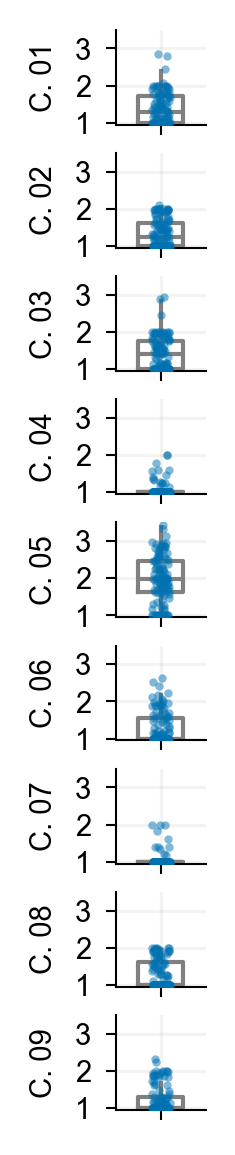

In [29]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = analysis_df[analysis_df['col'].isin([col])]
    g = plot_effective_numbers(long_df)
    g.savefig(f'{folder}/level-{level}_desc-eff-num-shapes.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-eff-num-shapes.png', transparent=True, dpi=300, bbox_inches='tight')

WHERE do transitions to alternate shapes happen: distributed across modes or concentrated in a few?

In [30]:
shape_transitions_df = []
for (col, sub), group in analysis_df.groupby(by=['col', 'sub']):
    # print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    
    comm_clusters = np.stack(group['clusters'].to_list())
    num_rare_shapes = np.sum(comm_clusters > 0, axis=0)
    avg_transitions = np.median(num_rare_shapes) / comm_clusters.shape[0] # divide by num_comms

    row = dict(
        sub=sub,
        sbm=SBM,
        col=col,
        num_rare_shapes=num_rare_shapes,
        avg_transitions=avg_transitions,
    )
    shape_transitions_df += [row]
shape_transitions_df = pd.DataFrame(shape_transitions_df)
shape_transitions_df['col'] = shape_transitions_df['col'].map(
    lambda x: x.replace('pi', '').replace('_', '').replace('aligned', '')
)

In [31]:
comm_clusters

array([[2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2],
       [2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [5, 2, 2, 5, 2, 2, 2, 0, 2, 5, 2, 3],
       [2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]])

In [32]:
shape_transitions_df

,sub,sbm,col,num_rare_shapes,avg_transitions
0,00,sbm-nd-h,1,"[7, 8, 7, 9, 9, 9, 9, 8, 7, 9, 9, 8, 9, 9, 8, ...",1.000000
1,01,sbm-nd-h,1,[9],1.000000
2,02,sbm-nd-h,1,"[7, 8, 7, 8, 9, 8, 8, 8, 9, 8, 8, 9, 7]",0.888889
3,03,sbm-nd-h,1,"[9, 9, 7, 9, 9, 7, 8, 9, 8, 9, 9, 9, 8]",1.000000
4,04,sbm-nd-h,1,[9],1.000000
...,...,...,...,...,...
106,84,sbm-nd-h,1,"[9, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]",1.000000
107,85,sbm-nd-h,1,"[8, 6, 9, 8, 8, 7, 8, 9, 9, 8, 9, 8, 9, 8]",0.888889
108,87,sbm-nd-h,1,"[8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8]",1.000000
109,89,sbm-nd-h,1,"[8, 8, 8, 9, 9, 8, 9, 9, 9, 9, 9, 8]",1.000000


In [33]:
def plot_rare_transitions(long_df: pd.DataFrame):
    nrows = sorted(long_df['col'].unique())
    nrows = np.max([int(c) for c in nrows])+1 #len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (col,), group in long_df.groupby(by=['col']):
        col = int(col)
        ax = axs[col]
        
        sns.boxplot(
            group, 
            ax=ax,
            y='avg_transitions',
            color='grey',
            fill=False, 
            width=0.5,
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax,
            y='avg_transitions',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5,
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylabel=f'Level {col}', ylim=[0, 1], yticks=[0, 0.5, 1],)
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

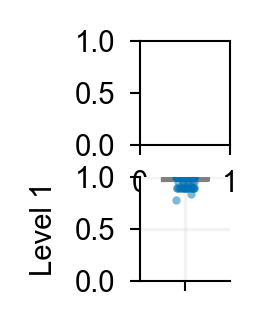

In [34]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

g = plot_rare_transitions(shape_transitions_df)
g.savefig(f'{folder}/desc-rare-transitions.svg', transparent=True, dpi=300, bbox_inches='tight')
g.savefig(f'{folder}/desc-rare-transitions.png', transparent=True, dpi=300, bbox_inches='tight')

HOW different are the shapes: stable fractions ?

In [35]:
ROI_SYS_path = f'{ROI_path}/canonical-systems/joanes'
v = np.loadtxt(f'{ROI_SYS_path}/desc-roi-vox-counts.csv') # n_rois

In [36]:
def compute_stable_fraction(strengths, configs, v, tol=0.01):
    comm_mask = ~np.all(configs <= tol, axis=1)
    diffs = np.abs(configs[comm_mask, :] - configs[comm_mask][:, [0]])
    wdiffs = diffs * strengths
    stable_frac = np.sum(v[comm_mask] * np.all(wdiffs <= tol, axis=1)) / np.sum(v * comm_mask) # account for voxels within ROIs
    stable_frac = np.round(stable_frac, decimals=3)
    return np.nan_to_num(stable_frac)

In [37]:
tol = 0.01
stable_fracs = analysis_df.apply(lambda row: compute_stable_fraction(row['strengths'], row['configs'], v, tol=tol), axis=1)

ValueError: operands could not be broadcast together with shapes (61,2) (3,) 

In [ ]:
stable_fracs_df = pd.concat(
    [
        analysis_df[['sub', 'sbm', 'col', 'comm']],
    ],
    axis=1,
)
stable_fracs_df['stable_frac'] = stable_fracs
stable_fracs_df[stable_fracs_df['col'].isin(cols[1:2])]

,sub,sbm,col,comm,stable_frac
2574,00,sbm-nd-h,pi_1_aligned,0,0.137
2575,01,sbm-nd-h,pi_1_aligned,0,1.000
2576,02,sbm-nd-h,pi_1_aligned,0,1.000
2577,03,sbm-nd-h,pi_1_aligned,0,1.000
2578,04,sbm-nd-h,pi_1_aligned,0,1.000
...,...,...,...,...,...
3163,66,sbm-nd-h,pi_1_aligned,8,1.000
3164,67,sbm-nd-h,pi_1_aligned,8,0.203
3165,68,sbm-nd-h,pi_1_aligned,8,1.000
3166,69,sbm-nd-h,pi_1_aligned,8,0.000


In [ ]:
def plot_stable_fractions(long_df: pd.DataFrame):
    nrows = sorted(long_df['comm'].unique())
    nrows = len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (comm,), group in long_df.groupby(by=['comm']):
        
        ax = axs[comm]
        
        sns.boxplot(
            group, 
            ax=ax, 
            y='stable_frac',
            color='grey',
            fill=False, 
            width=0.5, 
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='stable_frac',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5, 
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylim=[0-0.05, 1+0.05], yticks=[0, 0.5, 1])
        ax.set(ylabel=f'C. {comm+1:02d}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


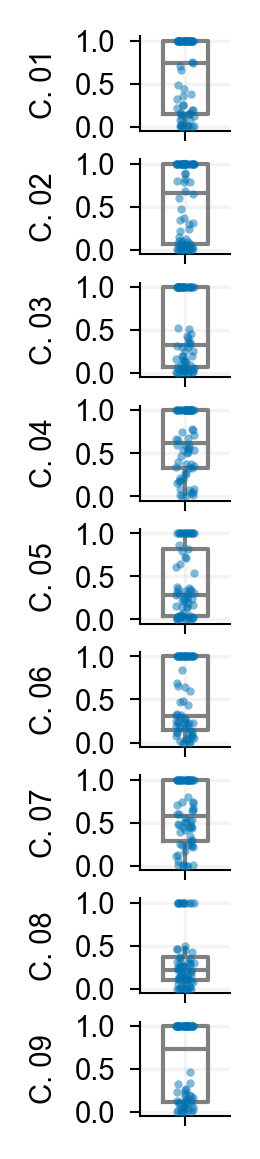

In [ ]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = stable_fracs_df[stable_fracs_df['col'].isin([col])]
    g = plot_stable_fractions(long_df)
    g.savefig(f'{folder}/level-{level}_desc-stable-fractions.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-stable-fractions.png', transparent=True, dpi=300, bbox_inches='tight')